In [1]:
%reload_ext autoreload
%autoreload 2

In [11]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats

import torch.optim as optim
import torch
import torch.nn as nn

from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt
from ipywidgets import widgets
from IPython.display import display,clear_output

import warnings
warnings.filterwarnings("ignore")

In [12]:
from dataset import GermanCreditDataset
from experiments import Benchmarking
from utils.logger_config import setup_logger
from tqdm import tqdm
from models.wrapper import PYTORCH_MODELS

logger = setup_logger()

In [13]:
from experiments.counterfactual import *
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, BaggingClassifier
from sklearn.svm import SVC
from models import PyTorchDNN, PyTorchLinearSVM, PyTorchRBFNet, PyTorchLogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.gaussian_process import GaussianProcessClassifier

dataset = GermanCreditDataset()
input_dim = dataset.get_dataframe().shape[1] - 1
seed = 0
torch.manual_seed(seed)
Avalues_method = 'avg'

counterfactual_algorithms = [
    'DiCE',
    # 'DisCount',
    # 'KNN',
]

experiment = Benchmarking(
    dataset=dataset,
    models=[
        (BaggingClassifier(),'sklearn'),
        # (GaussianProcessClassifier(),'sklearn'),
        # (PyTorchLogisticRegression(input_dim=input_dim), 'PYT'),
        # (PyTorchDNN(input_dim=input_dim), 'PYT'),
        # (PyTorchRBFNet(input_dim=input_dim, hidden_dim=input_dim), 'PYT'),
        # (PyTorchLinearSVM(input_dim=input_dim), 'PYT'),
        # (RandomForestClassifier(), 'sklearn'), 
        # (GradientBoostingClassifier(), 'sklearn'), 
        # (AdaBoostClassifier(), 'sklearn'), 
    ],
    shapley_methods=[
            "Train_Distri",
            "Train_OTMatch",
            "CF_UniformMatch",
            "CF_SingleMatch",
            "CF_OTMatch",
    ],
    distance_metrics=[
        'optimal_transport',
        'mean_difference',
        'median_difference',
        'max_mean_discrepancy',
    ],
    md_baseline=False,
)

experiment.train_and_evaluate_models(random_state=seed)
experiment.models_performance()

logger.info("\n\n------Compute Counterfactuals------")
sample_num = 50
model_counterfactuals = {}
for model, model_name in zip(experiment.models, experiment.model_names):
    model_counterfactuals[model_name] = {}

    for algorithm in counterfactual_algorithms:
        if algorithm == 'DisCount' and model_name not in PYTORCH_MODELS:
            logger.info(f'Skipping {algorithm} for {model_name} due to incompatability')
            continue
        logger.info(f'Computing {model_name} counterfactuals with {algorithm}')
        function_name = f"compute_{algorithm}_counterfactuals"
        try:
            func = globals()[function_name]
            model_counterfactuals[model_name][algorithm] = func(
                experiment.X_test,
                model = model,
                target_name = experiment.dataset.target_name,
                sample_num = sample_num,
                experiment=experiment,
            )
        except KeyError:
            logger.info(f"Function {function_name} is not working.")


INFO:root:BaggingClassifier accuracy: 0.7366666666666667
INFO:root:

------Compute Counterfactuals------
INFO:root:Computing BaggingClassifier counterfactuals with DiCE
100%|██████████| 50/50 [08:54<00:00, 10.69s/it]


In [17]:
logger.info("\n\n------Compute Action Policies------")
experiment.compute_intervention_policies(
    model_counterfactuals=model_counterfactuals,
    Avalues_method=Avalues_method,
);

INFO:root:

------Compute Action Policies------
INFO:root:Shapley values for BaggingClassifier using Train_Distri with counterfactual by DiCE


  0%|          | 0/50 [00:00<?, ?it/s]

INFO:root:Shapley values for BaggingClassifier using Train_OTMatch with counterfactual by DiCE


  0%|          | 0/50 [00:00<?, ?it/s]

INFO:root:Shapley values for BaggingClassifier using CF_UniformMatch with counterfactual by DiCE
INFO:root:Shapley values for BaggingClassifier using CF_SingleMatch with counterfactual by DiCE
INFO:root:Shapley values for BaggingClassifier using CF_OTMatch with counterfactual by DiCE


In [18]:
logger.info("\n\n------Evaluating Distance Performance Under Interventions------")
experiment.evaluate_distance_performance_under_interventions(
    intervention_num_list=[0, 10, 20, 30, 40, 50, 75, 100, 150, 200],
    trials_num=100,
    replace=False
)

INFO:root:

------Evaluating Distance Performance Under Interventions------
INFO:root:Policy for BaggingClassifier using Train_Distri with counterfactual by DiCE
INFO:root:Computing optimal_transport for (BaggingClassifier, DiCE, Train_Distri)
100%|██████████| 100/100 [00:01<00:00, 57.79it/s]
INFO:root:Computing mean_difference for (BaggingClassifier, DiCE, Train_Distri)
100%|██████████| 100/100 [00:01<00:00, 56.89it/s]
INFO:root:Computing median_difference for (BaggingClassifier, DiCE, Train_Distri)
100%|██████████| 100/100 [00:02<00:00, 48.65it/s]
INFO:root:Computing max_mean_discrepancy for (BaggingClassifier, DiCE, Train_Distri)
100%|██████████| 100/100 [00:02<00:00, 38.36it/s]
INFO:root:Policy for BaggingClassifier using Train_OTMatch with counterfactual by DiCE
INFO:root:Computing optimal_transport for (BaggingClassifier, DiCE, Train_OTMatch)
100%|██████████| 100/100 [00:02<00:00, 46.36it/s]
INFO:root:Computing mean_difference for (BaggingClassifier, DiCE, Train_OTMatch)
100%|███

In [19]:
# from copy import deepcopy
# distance_results_backup = deepcopy(experiment.distance_results)

In [20]:
# import pickle 
# with open(f"pickles/{dataset.name}_distance_results.pickle", "rb") as input_file:
#     experiment.distance_results.update(pickle.load(input_file))

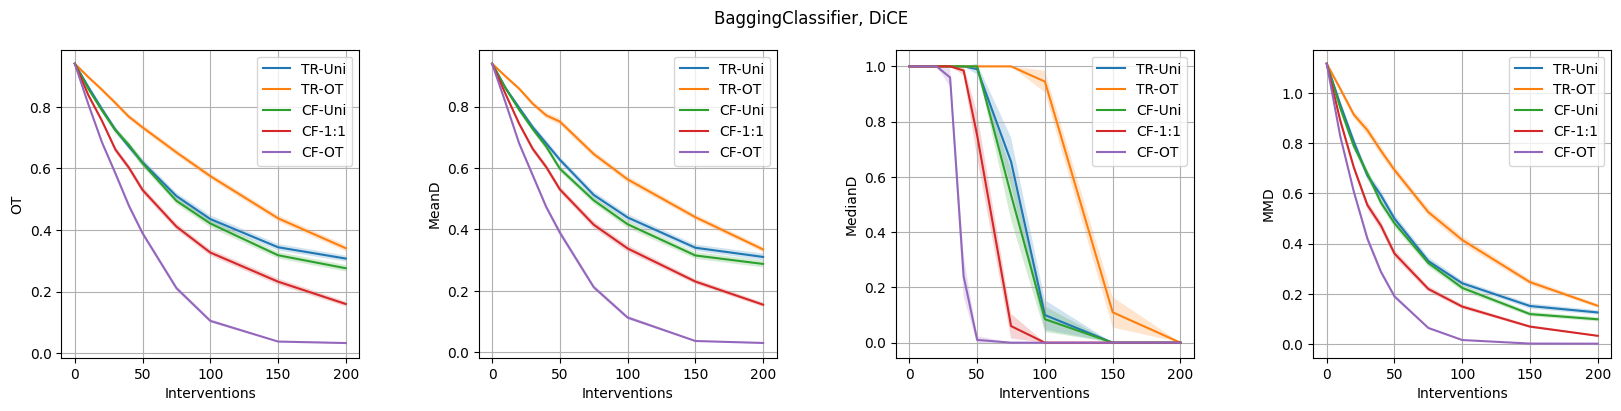

In [21]:
from experiments import plotting

plotting.intervention_vs_distance(experiment, save_to_file=False)

In [ ]:
# import pickle
# with open(f"pickles/{dataset.name}_distance_results.pickle", "wb") as output_file:
#     pickle.dump(experiment.distance_results, output_file)